# Data pre-process

### Imports and paths initialization

In [374]:
# imports for the whole notebook
import csv
import random
import warnings
import os
import argparse
import re
from datetime import datetime
from xml.etree import ElementTree as ET
import numpy as np
import pandas as pd
import rdflib
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import nltk
from owl2vec_star import owl2vec_star
from sdv import SDV
from sdv.evaluation import evaluate
from sdv.metrics.tabular import BinaryDecisionTreeClassifier, BinaryAdaBoostClassifier,\
    BinaryLogisticRegression, BinaryMLPClassifier, BNLikelihood, LogisticDetection,\
    CSTest, KSTest


def parse_args(args=None):
    """Finds a sub-tag of a source tag and inputs its value into a dictionary
        containing the current row's data

    Args:
        args (list-like):
            List of arguments to set. Uses default values if no args are passed.
    Returns:
        (argparse.ArgumentParser):
            Parsed arguments object.
    """
    parser = argparse.ArgumentParser(
        description='Data pre-process',
        usage=''
    )
    parser.add_argument('--data_dir', type=str, default='data')
    parser.add_argument('--onto_dir', type=str, default='ontology')
    parser.add_argument('--syn_data_dir', type=str, default='syn_data')
    parser.add_argument('--onto_to_embed', type=str, default='hpObo_hoom_ordo.owl')
    parser.add_argument('--embedding_cfg_path', type=str, default='./embedding.cfg')

    return parser.parse_args(args)


# set the path to your data folders here
args = parse_args(args=['--data_dir', '../persistent/data'])
onto_dir_path = os.path.join(args.data_dir, args.onto_dir)
syn_data_dir_path = os.path.join(args.data_dir, args.syn_data_dir)

if not os.path.exists(onto_dir_path):
    raise ValueError(f'You need an existing ontology directory with the XML dataset inside it, please create \'{onto_dir_path}\'')

if not os.path.exists(syn_data_dir_path):
    os.makedirs(syn_data_dir_path)

### Convert XML dataset to CSV

In [31]:
# Dataset: clinical signs and symptoms in rare diseases
# http://www.orphadata.org/cgi-bin/index.php (Phenotypes associated with rare disorders)


tree = ET.parse(os.path.join(onto_dir_path, 'en_product4.xml'))
root = tree.getroot()


headers = ['HPODisorderSetStatus_id', 'Disorder_id', 'OrphaCode', 'ExpertLink',
           'Name', 'DisorderType_id', 'DisorderType_name', 'DisorderGroup_id',
           'DisorderGroup_Name', 'HPODisorderAssociation_id', 'HPO_id',
           'HPOId', 'HPOTerm', 'HPOFrequency_id', 'HPOFrequency_Name',
           'DiagnosticCriteria_id', 'DiagnosticCriteria_Name', 'Source',
           'ValidationStatus', 'Online', 'ValidationDate']


def find_value(row_data, source_tag, target_tag_name, field, text=True):
    """Finds a sub-tag of a source tag and inputs its value into a dictionary
        containing the current row's data

    Args:
        row_data (dict):
            The data for the current row associated with the csv fields
        source_tag (Element):
            XML parent tag to search from
        target_tag_name (str):
            Name of the sub-tag to find
        field (str):
            Field in the csv file
        text (bool):
            Indicates if the value of the tag to retrieve is its inner text 
            or its id attribute
    Returns:
        tag (Element):
            Returns the found tag
    """
    tag = source_tag.find(target_tag_name)
    tag_v = ''

    if tag is not None:  # retrieving either the inner text or the id attribute of the tag
        if text:
            tag_v = tag.text
        elif (len(tag.attrib) > 0):
            tag_v = tag.attrib['id']
    row_data[field] = tag_v if tag_v is not None else ''

    return tag


with open(os.path.join(onto_dir_path, 'en_product4.csv'), 'w', encoding='utf-8') as fd:
    csvwriter = csv.DictWriter(fd, delimiter=',', fieldnames=headers)
    csvwriter.writeheader()

    # iterating through all the disorders
    for status in root.find('HPODisorderSetStatusList').findall('HPODisorderSetStatus'):
        row_data = {}
        row_data['HPODisorderSetStatus_id'] = status.attrib['id']

        disorder_tag = find_value(row_data, status, 'Disorder', 'Disorder_id', text=False)
        find_value(row_data, disorder_tag, 'OrphaCode', 'OrphaCode', text=True)
        find_value(row_data, disorder_tag, 'ExpertLink', 'ExpertLink', text=True)
        find_value(row_data, disorder_tag, 'Name', 'Name', text=True)

        disordertype_tag = find_value(row_data, disorder_tag, 'DisorderType', 'DisorderType_id', text=False)
        find_value(row_data, disordertype_tag, 'Name', 'DisorderType_name', text=True)
        disordergroup_tag = find_value(row_data, disorder_tag, 'DisorderGroup', 'DisorderGroup_id', text=False)
        find_value(row_data, disordergroup_tag, 'Name', 'DisorderGroup_Name', text=True)

        for field in ['Source', 'ValidationStatus', 'Online', 'ValidationDate']:
            find_value(row_data, status, field, field, text=True)

        # iterating through all the disorder associations and writing a row for each association
        for association in disorder_tag.find('HPODisorderAssociationList').findall('HPODisorderAssociation'):
            row_data['HPODisorderAssociation_id'] = association.attrib['id']

            hpo_tag = find_value(row_data, association, 'HPO', 'HPO_id', text=False)
            find_value(row_data, hpo_tag, 'HPOId', 'HPOId', text=True)
            find_value(row_data, hpo_tag, 'HPOTerm', 'HPOTerm', text=True)
            hpofrequency_tag = find_value(row_data, association, 'HPOFrequency', 'HPOFrequency_id', text=False)
            find_value(row_data, hpofrequency_tag, 'Name', 'HPOFrequency_Name', text=True)

            diagnosticcriteria_tag = find_value(row_data, association, 'DiagnosticCriteria', 'DiagnosticCriteria_id', text=False)
            find_value(row_data, diagnosticcriteria_tag, 'Name', 'DiagnosticCriteria_Name', text=True)

            csvwriter.writerow(row_data)

In [32]:
# Checking converted dataset
df = pd.read_csv(os.path.join(onto_dir_path, 'en_product4.csv'))
df.head(5)

HPODisorderSetStatus_id  Disorder_id  OrphaCode  \
0                        1            2         58   
1                        1            2         58   
2                        1            2         58   
3                        1            2         58   
4                        1            2         58   

                                          ExpertLink               Name  \
0  http://www.orpha.net/consor/cgi-bin/OC_Exp.php...  Alexander disease   
1  http://www.orpha.net/consor/cgi-bin/OC_Exp.php...  Alexander disease   
2  http://www.orpha.net/consor/cgi-bin/OC_Exp.php...  Alexander disease   
3  http://www.orpha.net/consor/cgi-bin/OC_Exp.php...  Alexander disease   
4  http://www.orpha.net/consor/cgi-bin/OC_Exp.php...  Alexander disease   

   DisorderType_id DisorderType_name  DisorderGroup_id DisorderGroup_Name  \
0            21394           Disease             36547           Disorder   
1            21394           Disease             36547           Disorder   
2            21394           Disease             36547           Disorder   
3            21394           Disease             36547           Disorder   
4            21394           Disease             36547           Disorder   

   HPODisorderAssociation_id  ...       HPOId                      HPOTerm  \
0                     327485  ...  HP:0000256                 Macrocephaly   
1                     327486  ...  HP:0001249      Intellectual disability   
2                     327487  ...  HP:0001250                     Seizures   
3                     327488  ...  HP:0001257                   Spasticity   
4                     327489  ...  HP:0001274  Agenesis of corpus callosum   

  HPOFrequency_id       HPOFrequency_Name DiagnosticCriteria_id  \
0           28412  Very frequent (99-80%)                   NaN   
1           28412  Very frequent (99-80%)                   NaN   
2           28412  Very frequent (99-80%)                   NaN   
3           28412  Very frequent (99-80%)                   NaN   
4           28412  Very frequent (99-80%)                   NaN   

   DiagnosticCriteria_Name Source ValidationStatus Online  \
0                      NaN    NaN                y      y   
1                      NaN    NaN                y      y   
2                      NaN    NaN                y      y   
3                      NaN    NaN                y      y   
4                      NaN    NaN                y      y   

          ValidationDate  
0  2016-06-01 00:00:00.0  
1  2016-06-01 00:00:00.0  
2  2016-06-01 00:00:00.0  
3  2016-06-01 00:00:00.0  
4  2016-06-01 00:00:00.0  

[5 rows x 21 columns]

### Dataset to triples, entities and relations

In [33]:
freq_assoc = {  # from csv frequency to frequency code
    'Obligate (100%)': 'O',
    'Very frequent (99-80%)': 'VF',
    'Frequent (79-30%)': 'F',
    'Occasional (29-5%)': 'OC',
    'Very rare (<4-1%)': 'VR',
    'Excluded (0%)': 'E'
}

freq_code_assoc = {  # from frequency code to output class
    'O': 'obligate',
    'VF': 'very_frequent',
    'F': 'frequent',
    'OC': 'occasional',
    'VR': 'very_rare',
    'E': 'excluded'
}

dc_association = {  # default: exclusion
    'Diagnostic criterion': 'diagnostic_criterion',
    'Pathognomonic sign': 'pathognomonic_sign',
}


def get_association_subclass(orpha, freq, hp):
    """Returns normalized association class

    Args:
        orpha (str):
            The prefixed Orphanet code
        freq (str):
            The frequency text
        hp (str):
            The prefixed HPO ID
    Returns:
        (str):
            The orphacode, hpo id and frequency association
    """
    return orpha + '_' + hp + '_FREQ:' + freq_assoc.get(freq)


def get_association_name(orpha, freq, hp):
    """Returns textual description of the association class

    Args:
        orpha (str):
            The prefixed Orphanet code
        freq (str):
            The frequency text
        hp (str):
            The prefixed HPO ID
    Returns:
        (str):
            The orphacode, hpo id and frequency association 
            textual_description_with_underscores
    """
    return get_normalized_string(orpha_entities.get(orpha) + ' and ' +
                                 hpo_entities.get(hp) + ' ' +
                                 freq_code_assoc.get(freq_assoc.get(freq)) +
                                 ' association')


def get_normalized_string(s):
    """Transforms a string to lowercase and replaces all whitespace runs with an underscore

    Args:
        s (str):
            String to normalize
    Returns:
        (str):
            The normalized string
    """
    return re.sub(r"\s+", '_', s.lower())


df_dataset = pd.read_csv(os.path.join(onto_dir_path, 'en_product4.csv'), 
                         dtype='object')
df_dataset['OrphaCode'] = df_dataset['OrphaCode'].map(lambda x: 'ORPHA:' + x)

# key is id, value is textual_description_with_underscores
assoc_entities = {}
dc_entities = {'diagnostic_criterion': 'diagnostic_criterion',
               'pathognomonic_sign': 'pathognomonic_sign',
               'exclusion': 'exclusion'}
freq_assoc_entities = {'obligate': 'obligate', 'very_frequent': 'very_frequent',
                       'frequent': 'frequent', 'occasional': 'occasional',
                       'very_rare': 'very_rare', 'excluded': 'excluded'}
hpo_entities = {}
orpha_entities = {}

has_object_triples = []  # association has_object HPOId
has_subject_triples = []  # association has_subject OrphaCode
has_frequency_triples = []  # association has_frequency FrequencyAssociation
has_diagnostic_criterion_triples = []  # association has_DC_attribute DC


# reading the dataset
for orpha, freq, hp, dc, \
    orpha_name, hpo_name in zip(df_dataset['OrphaCode'],
                                df_dataset['HPOFrequency_Name'],
                                df_dataset['HPOId'],
                                df_dataset['DiagnosticCriteria_Name'],
                                df_dataset['Name'],
                                df_dataset['HPOTerm']):
    if hp not in hpo_entities:
        hpo_entities[hp] = get_normalized_string(hpo_name)
    if orpha not in orpha_entities:
        orpha_entities[orpha] = get_normalized_string(orpha_name)

    ac = get_association_subclass(orpha, freq, hp)
    ac_name = get_association_name(orpha, freq, hp)
    assoc_entities[ac] = ac_name

    has_object_triples.append((ac, 'association_has_object', hp))
    has_subject_triples.append((ac, 'association_has_subject', orpha))
    has_frequency_triples.append((ac, 'has_frequency', freq_code_assoc.get(freq_assoc.get(freq))))
    has_diagnostic_criterion_triples.append((ac, 'has_DC_attribute', dc_association.get(dc, 'exclusion')))


# lists corresponding to each output file
triples = []
triples_names = []
entities = []
entities_names = []
relations = []

# subClassOf triples
entities_and_parent_class = [
    (assoc_entities, 'association'),
    (dc_entities, 'diagnostic_criteria'), 
    (freq_assoc_entities, 'frequency_association'), 
    (hpo_entities, 'HPO_Id'), 
    (orpha_entities, 'OrphaCode')
]
for (entities_dict, parent_class) in entities_and_parent_class:
    for k, v in entities_dict.items(): 
        triples.append((k, 'subClassOf', get_normalized_string(parent_class)))
        triples_names.append((v, 'subClassOf', parent_class))

# other properties triples
triples_and_entities = [
    (has_object_triples, hpo_entities), 
    (has_subject_triples, orpha_entities), 
    (has_frequency_triples, freq_assoc_entities), 
    (has_diagnostic_criterion_triples, dc_entities)
]
for (properties_triples, entities_dict) in triples_and_entities:
    for (s, r, o) in properties_triples:
        triples.append((s, r, o))
        triples_names.append((assoc_entities.get(s), r, entities_dict.get(o)))

# parent entities
for i, (k, v) in enumerate(entities_and_parent_class):
    parent = get_normalized_string(v)
    entities.append((i, parent))
    entities_names.append((i, parent))
# entities
parents_count = len(entities)
for i, (k, v) in enumerate({**assoc_entities, **dc_entities, **freq_assoc_entities,
                            **hpo_entities, **orpha_entities}.items()):
    entities.append((i+parents_count, k))
    entities_names.append((i+parents_count, v))

# relations
for i, r in enumerate(['subClassOf', 'association_has_object',
                       'association_has_subject', 'has_frequency', 
                       'has_DC_attribute']):
    relations.append((i, r))


# writing to the different files
lists_and_files = [
    (triples, 'triples.txt'), 
    (triples_names, 'triples_names.txt'),
    (entities, 'entities.dict'),
    (entities_names, 'entities_names.dict'),
    (relations, 'relations.dict')
]
for (l, n) in lists_and_files:
    with open(os.path.join(onto_dir_path, n), 'w') as f:
        for t in l:
            f.write('\t'.join(str(e) for e in t) + '\n')

### Merge ORDO, HP and HOOM ontologies using Protégé

https://bioportal.bioontology.org/ontologies/ORDO?p=summary 
    
https://bioportal.bioontology.org/ontologies/HP?p=summary 

https://bioportal.bioontology.org/ontologies/HOOM?p=summary: 'HOOM is a module that qualifies the annotation between a clinical entity and phenotypic abnormalities according to a frequency and by integrating the notion of diagnostic criterion.'

Using Protégé, merge HP (in OBO format, very important) into HOOM (OWL) and then ORDO (OWL) into the result of the merge to obtain a merge of the 3 ontologies, then export in OWL/XML format, and export in turtle format too.

### Seen and unseen RDs from the ontology

#### Loading the ontology graph

In [692]:
g = rdflib.Graph()
g.parse('../persistent/data/ontology/hpObo_hoom_ordo.ttl')

print(f'len g: {len(g)}')

len g: 4162248


#### Get all RDs and their corresponding groups

In [282]:
# part of <http://www.orpha.net/ORDO/Orphanet_C021>

groups_query = """
SELECT ?rd_g ?rd
WHERE {
    ?rd_uri rdf:type owl:Class;
            <http://www.orpha.net/ORDO/Orphanet_C021> ?rd_g .
    BIND (STR(?rd_uri) AS ?rd) .
}
"""

groups_qres = g.query(groups_query)

#### Get RDs seen in Association classes

In [279]:
rds_query = """
SELECT DISTINCT ?rd
{
    ?subject rdfs:subClassOf :Association .
    BIND(REPLACE(STR(?subject), ".*Orpha:([0-9]+).*", "$1") AS ?sub) .
    BIND(CONCAT("http://www.orpha.net/ORDO/Orphanet_", ?sub) AS ?rd) .
}
"""

rds_qres = g.query(rds_query)

#### Get RDs from a specific subgroup

In [1]:
# http://www.orpha.net/ORDO/Orphanet_182111: Respiratory malformation

selected_group_query = """
SELECT DISTINCT ?rd ?label
WHERE {
    ?subject rdfs:subClassOf :Association .
    BIND(REPLACE(STR(?subject), ".*Orpha:([0-9]+).*", "$1") AS ?sub) .
    BIND(CONCAT("http://www.orpha.net/ORDO/Orphanet_", ?sub) AS ?rd) .
    BIND (URI(?rd) AS ?rd_uri) .

    ?rd_uri <http://www.orpha.net/ORDO/Orphanet_C021> "http://www.orpha.net/ORDO/Orphanet_182111" ;
            rdfs:label ?label .
    BIND (STR(?rd_uri) AS ?rd) .
    FILTER REGEX(?label, "[^ORPHA:0-9]") .
}
"""

selected_group_qres = g.query(selected_group_query)
for row in selected_group_qres:
    print(f'{row.label}: {row.rd}')

NameError: name 'g' is not defined

In [695]:
# http://www.orpha.net/ORDO/Orphanet_207018: Rare hereditary metabolic disease with peripheral neuropathy (leukemia-related)

selected_group_query = """
SELECT DISTINCT ?rd ?label
WHERE {
    ?subject rdfs:subClassOf :Association .
    BIND(REPLACE(STR(?subject), ".*Orpha:([0-9]+).*", "$1") AS ?sub) .
    BIND(CONCAT("http://www.orpha.net/ORDO/Orphanet_", ?sub) AS ?rd) .
    BIND (URI(?rd) AS ?rd_uri) .

    ?rd_uri <http://www.orpha.net/ORDO/Orphanet_C021> "http://www.orpha.net/ORDO/Orphanet_207018" ;
            rdfs:label ?label .
    BIND (STR(?rd_uri) AS ?rd) .
    FILTER REGEX(?label, "[^ORPHA:0-9]") .
}
"""

selected_group_qres = g.query(selected_group_query)
for row in selected_group_qres:
    print(f'{row.label}: {row.rd}')

Beta-mannosidosis: http://www.orpha.net/ORDO/Orphanet_118
Adrenomyeloneuropathy: http://www.orpha.net/ORDO/Orphanet_139399
Abetalipoproteinemia: http://www.orpha.net/ORDO/Orphanet_14
Adult polyglucosan body disease: http://www.orpha.net/ORDO/Orphanet_206583
Choreoacanthocytosis: http://www.orpha.net/ORDO/Orphanet_2388
De Barsy syndrome: http://www.orpha.net/ORDO/Orphanet_2962
Tangier disease: http://www.orpha.net/ORDO/Orphanet_31150
Fabry disease: http://www.orpha.net/ORDO/Orphanet_324
Homocystinuria due to methylene tetrahydrofolate reductase deficiency: http://www.orpha.net/ORDO/Orphanet_395
Gyrate atrophy of choroid and retina: http://www.orpha.net/ORDO/Orphanet_414
Cataract-growth hormone deficiency-sensory neuropathy-sensorineural hearing loss-skeletal dysplasia syndrome: http://www.orpha.net/ORDO/Orphanet_436174
Non-progressive predominantly posterior cavitating leukoencephalopathy with peripheral neuropathy: http://www.orpha.net/ORDO/Orphanet_436271
Ocular anomalies-axonal neuro

#### Get RDs containing a certain word

In [693]:
selected_group_query = """
SELECT DISTINCT ?rd ?label
WHERE {
    ?subject rdfs:subClassOf :Association .
    BIND(REPLACE(STR(?subject), ".*Orpha:([0-9]+).*", "$1") AS ?sub) .
    BIND(CONCAT("http://www.orpha.net/ORDO/Orphanet_", ?sub) AS ?rd) .
    BIND (URI(?rd) AS ?rd_uri) .

    ?rd_uri rdfs:label ?label .
    FILTER CONTAINS(?label, "leukemia") .
    FILTER REGEX(?label, "[^ORPHA:0-9]") .
    BIND (STR(?rd_uri) AS ?rd) .
}
"""

selected_group_qres = g.query(selected_group_query)
for row in selected_group_qres:
    print(f'{row.label}: {row.rd}')

Acute erythroid leukemia: http://www.orpha.net/ORDO/Orphanet_318
Deafness-lymphedema-leukemia syndrome: http://www.orpha.net/ORDO/Orphanet_3226
Acute monoblastic/monocytic leukemia: http://www.orpha.net/ORDO/Orphanet_514
Acute myelomonocytic leukemia: http://www.orpha.net/ORDO/Orphanet_517
Acute promyelocytic leukemia: http://www.orpha.net/ORDO/Orphanet_520
Chronic myeloid leukemia: http://www.orpha.net/ORDO/Orphanet_521


#### Building a dictionary of RD groups and their RDs seen in Association classes

In [696]:
rd_list = []
rd_groups_dict = {}

# set of all RDs
for row in rds_qres:
    rd_list.append(str(row.rd))
rd_set = set(rd_list)

# RD groups dictionary
for row in groups_qres:
    rd = str(row.rd)
    rd_g = str(row.rd_g)
    if rd in rd_set:
        if rd_g not in rd_groups_dict:
            rd_groups_dict[rd_g] = []
        if rd not in rd_groups_dict[rd_g]:
            rd_groups_dict[rd_g].append(rd)

print(f'Number of unique, seen in Association classes RDs: {len(rd_list)} {len(rd_set)}\nNumber of RD groups: {len(rd_groups_dict)}')

len_sum = sum(len(dct) for dct in rd_groups_dict.values())

print(f'Total number of RDs in groups: {len_sum}\nAverage: {len_sum/len(rd_groups_dict)}')

Number of unique, seen in Association classes RDs: 4345 4345
Number of RD groups: 1692
Total number of RDs in groups: 10484
Average: 6.196217494089835


#### Building sets of seen and unseen RDs

In [704]:
# seen and unseen RDs sets
seen_rds_set = set()
unseen_rds_set = set()


def populating_rd_sets(method='no_groups', shuffle=False, unseen_pct=0.2, selected_seen_rds=[], selected_unseen_rds=[]):
    """Builds sets of seen and unseen RDs for synthetic data generation.
       The populated sets are global variables outside this function.

    Args:
        method (str):
            Method to choose to build the sets, one of 'no_groups', 'parts_groups', 'whole_groups', 'selected_rds':
            'no_groups' adds a guaranteed percentage (unseen_pct) of all RDs to unseen RDs, regardless of their groups.
            'parts_groups' adds a percentage (unseen_pct) of RDs inside groups to unseen RDs, 
                eventually stopping if unseen_rds_set_set exceeds the unseen_pct of the RDs total.
            'whole_groups' adds all RDs of each group to unseen RDs until unseen_rds_set_set exceeds the unseen_pct of the RDs total.
            'selected_rds' only adds the selected rds to unseen RDs.
            Defaults to 'no_groups'.
        shuffle (bool)
            Whether to shuffle the order of the rd groups dictionary. Defaults to False.
        rds_pct (float):
            The wished ratio of unseen RDs. Defaults to 0.2.
        selected_seen_rds (list-like):
            The list-like object of the IRIs of seen RDs, only used if the method is 'selected_rds'.
            If empty while selected_unseen_rds is not empty, all remaining RDs will be "seen".
        selected_unseen_rds (list-like):
            The list-like object of the IRIs of unseen RDs, only used if the method is 'selected_rds'.
    """

    methods = {'no_groups', 'parts_groups', 'whole_groups', 'selected_rds'}
    if method not in methods:
        raise Exception(f'Unknown method "{method}", should be one of {methods}')

    total_rds = len(rd_set)

    # building the sets
    if method == 'no_groups':
        indexes = [i for i in range(len(rd_list))]
        if shuffle:
            random.shuffle(indexes)
        for ind in indexes:  # iterating on all RDs
            rd = rd_list[ind]
            if (rd not in seen_rds_set) and (rd not in unseen_rds_set):
                if len(unseen_rds_set) > total_rds*unseen_pct:
                    seen_rds_set.add(rd)
                else:
                    unseen_rds_set.add(rd)

    elif method == 'parts_groups':
        keys = list(rd_groups_dict.keys())
        if shuffle:
            random.shuffle(keys)
        for rd_group in keys:  # iterating on groups
            rds = rd_groups_dict[rd_group]
            # counting unseen RDs to stop at rds*pct threshold
            unseen_cnt = 0
            if len(unseen_rds_set) > total_rds*unseen_pct:
                # no more RDs added to unseen RDs if unseen_rds_set is over the threshold
                unseen_cnt = len(unseen_rds_set)
            for rd in rds:
                if rd in unseen_rds_set:
                    unseen_cnt += 1
                else:
                    if rd not in seen_rds_set:
                        if unseen_cnt > len(rds)*unseen_pct:
                            seen_rds_set.add(rd)
                        else:
                            unseen_rds_set.add(rd)
                            unseen_cnt += 1

    elif method == 'whole_groups':  # pct of unseen RDs not guaranteed
        keys = list(rd_groups_dict.keys())
        if shuffle:
            random.shuffle(keys)
        for rd_group in keys:  # iterating on groups
            rds = rd_groups_dict[rd_group]
            if len(unseen_rds_set) > total_rds*unseen_pct:
                for rd in rds:
                    if (rd not in seen_rds_set) and (rd not in unseen_rds_set):
                        seen_rds_set.add(rd)
            else:
                for rd in rds:
                    if rd not in unseen_rds_set:
                        unseen_rds_set.add(rd)

    elif method == 'selected_rds':
        for rd in selected_unseen_rds:  # iterating on chosen groups
            if rd in rd_set:
                if rd not in unseen_rds_set:
                    unseen_rds_set.add(rd)
            else:
                raise Exception(f'Unknown RD {rd}')
        # adding the seen_rds_set
        if len(selected_seen_rds) > 0:
            for rd in selected_seen_rds:  # iterating on chosen groups
                if rd in rd_set:
                    if (rd not in seen_rds_set) and (rd not in unseen_rds_set):
                        seen_rds_set.add(rd)
                else:
                    raise Exception(f'Unknown RD {rd}')
        else:  # adding all remaining RDs
            for rds in rd_groups_dict.values():
                for rd in rds:
                    if (rd not in seen_rds_set) and (rd not in unseen_rds_set):
                        seen_rds_set.add(rd)

    if method not in ['no_groups', 'selected_rds']:
        # TODO: allow some of these to be added to unseen_rds_set?
        # adding the RDs that aren't part of a RD group, in the seen set
        for rd in rd_list:
            if (rd not in seen_rds_set) and (rd not in unseen_rds_set):
                seen_rds_set.add(rd)

    print(f'Number of seen RDs: {len(seen_rds_set)} ({(len(seen_rds_set)/len(rd_set)*100):.2f}%)\nNumber of unseen RDs: {len(unseen_rds_set)} ({(len(unseen_rds_set)/len(rd_set)*100):.2f}%)')


"""
# Selected RDs from 2 disorder subgroups (5 seen + 2/3 unseen for each group)
# Leukodystrophy (brain) and Respiratory diseases
seen = [
    "http://www.orpha.net/ORDO/Orphanet_1120",  # Lung agenesis-heart defect-thumb anomalies syndrome
    "http://www.orpha.net/ORDO/Orphanet_2414",  # Congenital pulmonary lymphangiectasia
    "http://www.orpha.net/ORDO/Orphanet_2444",  # Congenital pulmonary airway malformation
    "http://www.orpha.net/ORDO/Orphanet_2470",  # Matthew-Wood syndrome
    "http://www.orpha.net/ORDO/Orphanet_2257",  # Primary pulmonary hypoplasia
    "http://www.orpha.net/ORDO/Orphanet_135",  # CACH syndrome
    "http://www.orpha.net/ORDO/Orphanet_141",  # Canavan disease
    "http://www.orpha.net/ORDO/Orphanet_512",  # Metachromatic leukodystrophy
    "http://www.orpha.net/ORDO/Orphanet_43",  # X-linked adrenoleukodystrophy
    "http://www.orpha.net/ORDO/Orphanet_139444"  # Leukoencephalopathy with bilateral anterior temporal lobe cysts
]
unseen = [
    "http://www.orpha.net/ORDO/Orphanet_3346",  # Tracheal agenesis
    "http://www.orpha.net/ORDO/Orphanet_185",  # Scimitar syndrome
    "http://www.orpha.net/ORDO/Orphanet_774",  # Hereditary hemorrhagic telangiectasia
    "http://www.orpha.net/ORDO/Orphanet_466934",  # VPS11-related autosomal recessive hypomyelinating leukodystrophy
    "http://www.orpha.net/ORDO/Orphanet_909"  # Cerebrotendinous xanthomatosis
]"""

# Leukemia RDs
seen = [
    "http://www.orpha.net/ORDO/Orphanet_231401",  # Alpha-thalassemia-myelodysplastic syndrome
    "http://www.orpha.net/ORDO/Orphanet_29073",  # Multiple myeloma
    "http://www.orpha.net/ORDO/Orphanet_729",  # Polycythemia vera
    "http://www.orpha.net/ORDO/Orphanet_3226",  # Deafness-lymphedema-leukemia syndrome
    "http://www.orpha.net/ORDO/Orphanet_86843",  # Acute panmyelosis with myelofibrosis
    "http://www.orpha.net/ORDO/Orphanet_98827",  # Unclassified myelodysplastic syndrome
    "http://www.orpha.net/ORDO/Orphanet_514",  # Acute monoblastic/monocytic leukemia
    "http://www.orpha.net/ORDO/Orphanet_517",  # Acute myelomonocytic leukemia
    "http://www.orpha.net/ORDO/Orphanet_318",  # Acute erythroid leukemia
    "http://www.orpha.net/ORDO/Orphanet_824",  # Primary myelofibrosis
    "http://www.orpha.net/ORDO/Orphanet_520",  # Acute promyelocytic leukemia
    "http://www.orpha.net/ORDO/Orphanet_139399"  # Adrenomyeloneuropathy
]
unseen = [
    "http://www.orpha.net/ORDO/Orphanet_3318",  # Essential thrombocythemia
    "http://www.orpha.net/ORDO/Orphanet_521",  # Chronic myeloid leukemia
    "http://www.orpha.net/ORDO/Orphanet_512"  # Metachromatic leukodystrophy
]

populating_rd_sets(method='selected_rds', selected_seen_rds=seen, selected_unseen_rds=unseen)

Number of seen RDs: 12 (0.28%)
Number of unseen RDs: 5 (0.12%)


### Synthetic data generation from the ontology

In [ ]:
frequency_dict = {  # frequency ids + associated probability
    28405: 1,  # Obligate (100%)
    28412: 0.895,  # Very frequent (99-80%)
    28419: 0.545,  # Frequent (79-30%)
    28426: 0.17,  # Occasional (29-5%)
    28433: 0.025,  # Very rare (<4-1%)
    28440: 0  # Excluded (0%)
}


def get_orpha_iri(orphacode):
    """Gets the IRI of an OrphaCode.

    Args:
        orphacode (int):
            The unique code of the rare disease in the ORDO ontology.
    Returns:
        (str):
            The Orphanet IRI.
    """
    return f'http://www.orpha.net/ORDO/Orphanet_{orphacode}'


def gen_syn_data(patients_per_rd=10, use_ontology_rds=True, gen_small_file=False, print_every=0, del_col_th=0, sort=True):
    """Generates synthetic seen and unseen data from the ontology into files.

    Args:
        patients_per_rd (int):
            Number of generated patients per RD. Defaults to 10.
        use_ontology_rds (bool):
            Whether to use the seen and unseen RD sets obtained from ontology queries.
            Defaults to True.
        gen_small_file (bool):
            Whether to generate very small files to debug the model or the full ones.
            Defaults to False.
        print_every (int):
            Each number of patients to print progress during data generation (0 = no print).
            Defaults to 0.
        del_col_th (int):
            How few values for a column to be deleted (not inclusive), 0 for no deletion. Defaults to 0.
        sort (str):
            Whether to alphabetically sort RDs in output files. Defaults to True.
    """
    df = pd.read_csv(os.path.join(onto_dir_path, 'en_product4.csv'))

    # Deleting RDs not seen in the ontology.
    df['Orpha_URI'] = 'http://www.orpha.net/ORDO/Orphanet_' + df['OrphaCode'].astype(str)
    df = df.loc[df['Orpha_URI'].isin(seen_rds_set.union(unseen_rds_set))]

    if gen_small_file:
        # only the first 10 rows
        grouped = df.groupby('Name', sort=False)
        df = pd.concat([group for name, group in grouped][:10])
    grouped = df.groupby('Name', sort=False)

    rd_count = grouped.ngroups
    unique_hps = df.HPOTerm.unique()
    total_hp_count = len(unique_hps)

    print(f'{rd_count} unique rare diseases, {total_hp_count} unique phenotypes')

    # Dictionary of phenotypes and their position in the data row
    phenotypes = unique_hps.tolist()
    phenotypes_dict = {hp: i for i, hp in enumerate(phenotypes)}

    header = [['rare_disease'] + phenotypes]
    seen_patients_data = []
    unseen_patients_data = []

    distribution_check = {  # value: count of patients with hp + maximum count of patients that could've had the hp
        28405: [0, 0],  # Obligate (100%)
        28412: [0, 0],  # Very frequent (99-80%)
        28419: [0, 0],  # Frequent (79-30%)
        28426: [0, 0],  # Occasional (29-5%)
        28433: [0, 0],  # Very rare (<4-1%)
        28440: [0, 0]  # Excluded (0%)
    }

    patients_count = 0

    if not use_ontology_rds:
        # Only seen RDs are generated if the sets built from the ontology aren't used
        vectorize = np.vectorize(get_orpha_iri)
        seen_rds = vectorize(df.OrphaCode.unique())
        unseen_rds = []

    for group_nb, (name, group) in enumerate(grouped):  # for each RD
        hp_count = len(group)
        # generate patients_per_rd patients for each RD
        for patient in range(patients_count, patients_count+patients_per_rd):
            temp_hp = []
            proba_results = np.random.rand(hp_count)  # generating random floats for probabilities
            rd_n = ''
            rd_iri = ''
            for i, (orphacode, rd_name, hp_name, frequency_id) in enumerate(zip(
                                                            group['OrphaCode'],
                                                            group['Name'],
                                                            group['HPOTerm'],
                                                            group['HPOFrequency_id'])):
                distribution_check.get(frequency_id)[1] += 1
                if rd_n == '':
                    rd_n = rd_name
                    rd_iri = get_orpha_iri(orphacode)
                if (proba_results[i] >= 1 - frequency_dict[frequency_id]):  # comparing generated float and proba
                    temp_hp.append(hp_name)
                    distribution_check.get(frequency_id)[0] += 1

            if len(temp_hp) > 0:
                row = np.zeros((total_hp_count,), dtype=int)
                for hp in temp_hp:
                    row[phenotypes_dict.get(hp)] = 1
                if use_ontology_rds:
                    if rd_iri in seen_rds_set:
                        seen_patients_data.append(np.concatenate([[rd_n], row]))
                    elif rd_iri in unseen_rds_set:
                        unseen_patients_data.append(np.concatenate([[rd_n], row]))
                    else:
                        print(f'Unknown RD {rd_n}')
                        break  # skipping unknown RD
                else:
                    if rd_iri in seen_rds:
                        seen_patients_data.append(np.concatenate([[rd_n], row]))
                    elif rd_iri in unseen_rds:
                        unseen_patients_data.append(np.concatenate([[rd_n], row]))
                    else:
                        print(f'Unknown RD {rd_n}')
                        break  # skipping unknown RD

                if print_every > 0:
                    if patients_count % print_every == 0:
                        print(f'{patients_count}/{patients_per_rd*rd_count} patients generated')

                patients_count += 1

    # index at which the unseen patients data starts
    unseen_index = len(seen_patients_data) + 1
    full_data = np.array(header + seen_patients_data + unseen_patients_data)

    if del_col_th > 0:
        # remove columns with < del_col_th patients that have this phenotype
        col_sum = np.sum(full_data[1:, 1:].astype(int), axis=0)
        mask = [True] + [s >= del_col_th for s in col_sum]
        full_data = np.transpose(np.transpose(full_data)[mask])
    seen_patients_data = full_data[:unseen_index]
    headers = seen_patients_data[0]

    # Build the final datasets
    seen_patients_data = pd.DataFrame(seen_patients_data[1:], columns=headers)
    seen_patients_data = seen_patients_data.loc[:, (seen_patients_data != '0').any(axis=0)]
    if sort:
        seen_patients_data = seen_patients_data.sort_values(by=['rare_disease'])

    unseen_patients_data = full_data[unseen_index:]
    unseen_unique = np.unique(unseen_patients_data[:, :1])
    unseen_patients_data = pd.DataFrame(unseen_patients_data, columns=headers)
    unseen_patients_data = unseen_patients_data[seen_patients_data.columns]
    if sort:
        unseen_patients_data = unseen_patients_data.sort_values(by=['rare_disease'])

    print(f'{len(seen_patients_data)} seen patients generated ({len(seen_patients_data.columns)} columns), {len(unseen_patients_data)} unseen patients generated ({len(unseen_patients_data.columns)} columns), writing to files')

    # writing the 2 data files and the list of unseen_rds
    seen_patients_data.to_csv(
        os.path.join(syn_data_dir_path, ('small_' if gen_small_file else '') + 'syn_patients_data_seen.csv'),
        encoding='utf-8', index=False, header=True
    )
    if len(unseen_patients_data) > 0:
        unseen_patients_data.to_csv(
            os.path.join(syn_data_dir_path, ('small_' if gen_small_file else '') + 'syn_patients_data_unseen.csv'),
            encoding='utf-8', index=False, header=True
        )
        with open(os.path.join(syn_data_dir_path, ('small_' if gen_small_file else '') + 'unseen_rds.txt'), 'w') as unseen_file:
            for rd in unseen_unique:
                unseen_file.write(f'{rd}\n')

    print(f'Total RDs: {rd_count}, {rd_count-len(unseen_unique)} seen RDs, {len(unseen_unique)} unseen RDs')

    return distribution_check


distributions = gen_syn_data(patients_per_rd=50, gen_small_file=False, print_every=1000, del_col_th=45, sort=True)

#### Plotting the obtained HP frequencies

[(28405, [20, 20]), (28412, [282, 330]), (28419, [669, 1220]), (28426, [152, 900]), (28433, [3, 120]), (28440, [0, 10])]


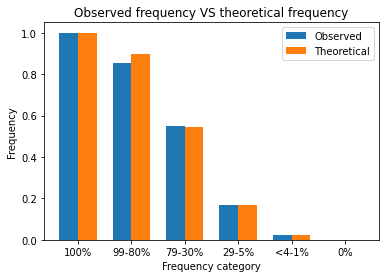

In [433]:
def show_distributions(frequency_obs, frequency_th):
    """Visually compare theoretical and observed HP frequency.

    Args:
        frequency_obs (list-like):
            List of observed frequency values.
        frequency_th (list-like):
            List of theoretical frequency values.
    """
    index = np.arange(len(frequency_obs))
    bar_width = 0.35

    fix, ax = plt.subplots()

    ax.bar(index, frequency_obs, bar_width, label='Observed')
    ax.bar(index+bar_width, frequency_th, bar_width, label='Theoretical')

    ax.set_xlabel('Frequency category')
    ax.set_ylabel('Frequency')
    ax.set_title('Observed frequency VS theoretical frequency')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(['100%', '99-80%', '79-30%', '29-5%', '<4-1%', '0%'])
    ax.legend()

    plt.show()


sorted_items = sorted(distributions.items(), key=lambda x: x[0])
print(sorted_items)
# Calculating the observed frequencies
frequency_obs = [t[1][0]/t[1][1] if t[1][0] != 0 else t[1][0] for t in sorted_items]
sorted_freq = sorted(frequency_dict.items(), key=lambda x: x[0])
frequency_th = [x[1] for x in sorted_freq]

show_distributions(frequency_obs, frequency_th)

### ORDO and HPO URIs dictionaries

In [434]:
# normalized names to ORDO URIs and HPO URIs

df = pd.read_csv(os.path.join(onto_dir_path, 'en_product4.csv'))

df_hp = df[['HPOTerm', 'HPOId']].drop_duplicates()
df_rd = df[['Name', 'OrphaCode']].drop_duplicates()
df_hp['HPOId'] = 'http://purl.obolibrary.org/obo/' + df_hp['HPOId'].str.replace(':', '_')
df_rd['OrphaCode'] = 'http://www.orpha.net/ORDO/Orphanet_' + df_rd['OrphaCode'].astype(str)

df_hp.to_csv(os.path.join(onto_dir_path, 'HPO.dict'), sep=';', encoding='utf-8', index=False, header=False)
df_rd.to_csv(os.path.join(onto_dir_path, 'ORDO.dict'), sep=';', encoding='utf-8', index=False, header=False)

### Embedding the ontology with Owl2Vec*

In [44]:
# Sentence tokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
output_folder = '../persistent/data/ontology/embeddings/hpObo_hoom_ordo'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

"""
Parameters:
    ontology_file
    config_file
    uri_doc
    lit_doc
    mix_doc
    -> modify the cfg file for more params (cache dir, epochs, etc.)
"""
gensim_model = owl2vec_star.extract_owl2vec_model(None, "./embedding.cfg", True, True, True)

# Gensim format
gensim_model.save(os.path.join(output_folder, 'ontology.embeddings'))

# Text format (not required)
gensim_model.wv.save_word2vec_format(os.path.join(output_folder, "ontology.embeddings.txt"), binary=False)

#### Embeddings check

In [ ]:
#Embedding vectors generated above
model = KeyedVectors.load(output_folder+"ontology.embeddings", mmap='r')
wv = model.wv

word = 'http://www.orpha.net/ORDO/Orphanet_556985'
vector = wv[word]  # Get numpy vector of a word
print(f"Vector for {word}: {vector}")

#Most similar cosine similarity
result1 = wv.most_similar(positive=[word])
print(result1)

#Most similar entities: cosmul
result2 = wv.most_similar_cosmul(positive=[word])
print(result2)

### Sample synthetic data from the trained model

In [ ]:
now = datetime.now()
current_time = now.strftime("%Y_%m_%d_%H_%M_%S")

nb_rows = 600
model_file = '../persistent/model/leukemia_600_50_5000_epochs_onto_dp_cgans_model.pkl'
seen_save_path = f'../persistent/model/{current_time}_seen_sample_{nb_rows}_rows.csv'
unseen_save_path = f'../persistent/model/{current_time}_unseen_sample_{nb_rows}_rows.csv'

model = SDV.load(model_file)

# Unseen ZSL sampling
unseen_file = '../persistent/data/syn_data/unseen_rds_3_leukemia.txt'
picked_unseen_rds = []
with open(unseen_file) as uf:
    for rd in uf:
        picked_unseen_rds.append(rd.strip())

print(f'Sampling {nb_rows} seen rows')
model.sample(nb_rows).to_csv(seen_save_path)
print(f'Sampling {nb_rows} unseen rows')
model.sample(nb_rows, unseen_rds=picked_unseen_rds).to_csv(unseen_save_path)

### Evaluate generated datasets

In [ ]:
# Ingore pandas and python warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None


def print_similarity(title, fsp_fn, fup_fn, ssp_fn, sup_fn):
    """Compute various metrics to evaluate the generated datasets.

    Args:
        title (str):
            Info about the dataset and training.
        fsp_fn (str):
            Fake seen patients dataset (generated from the ontology).
        fup_fn (str):
            Fake unseen patients dataset (generated from the ontology).
        ssp_fn (str):
            Sampled seen patients dataset (sampled from the model).
        sup_fn (str):
            Sampled unseen patients dataset (sampled from the model).
    """
    sampled_seen_patients = pd.read_csv(ssp_fn)
    sampled_seen_patients.drop(columns=sampled_seen_patients.columns[0], axis=1, inplace=True)
    sampled_unseen_patients = pd.read_csv(sup_fn)
    sampled_unseen_patients.drop(columns=sampled_unseen_patients.columns[0], axis=1, inplace=True)
    fake_seen_patients = pd.read_csv(fsp_fn)
    fake_unseen_patients = pd.read_csv(fup_fn)
    # Aligning the fake unseen datasets' columns with the columns of the unseen sampled dataset
    fake_unseen_patients = fake_unseen_patients[sampled_unseen_patients.columns]

    print(f'Results for {title}')
    print(f'Fake Seen Patients: {len(fake_seen_patients)}x{len(fake_seen_patients.columns)} Fake Unseen Patients: {len(fake_unseen_patients)}x{len(fake_unseen_patients.columns)} Sampled Seen Patients: {len(sampled_seen_patients)}x{len(sampled_seen_patients.columns)} Sampled Unseen Patients: {len(sampled_unseen_patients)}x{len(sampled_unseen_patients.columns)}')
    print(f'Similarity between fake and sampled seen patients data: {evaluate(fake_seen_patients, sampled_seen_patients):.3f}')
    print(f'Similarity between fake and sampled unseen patients data: {evaluate(fake_unseen_patients, sampled_unseen_patients):.3f}')

    for (text, fp, sp) in [('Seen', fake_seen_patients, sampled_seen_patients), ('Unseen', fake_unseen_patients, sampled_unseen_patients)]:
        print(f"CSTest, {text}: {CSTest.compute(fp, sp):.3f}")
        print(f"KSTest, {text}: {KSTest.compute(fp, sp):.3f}")
        print(f"BDT, {text}: {BinaryDecisionTreeClassifier.compute(fp, sp, target='rare_disease'):.3f}")
        print(f"Ada, {text}: {BinaryAdaBoostClassifier.compute(fp, sp, target='rare_disease'):.3f}")
        print(f"LR, {text}: {BinaryLogisticRegression.compute(fp, sp, target='rare_disease'):.3f}")
        print(f"MLP, {text}: {BinaryMLPClassifier.compute(fp, sp, target='rare_disease'):.3f}")
        # print(f"BN, {text}: {BNLikelihood.compute(fp, sp):.3f}")
        print(f"LD, {text}: {LogisticDetection.compute(fp, sp):.3f}")

    print('')  # line break


print_similarity(title='Brain and lung RDs, 100x50 dataset, 5000 epochs',
                 fsp_fn='../persistent/data/syn_data/syn_patients_data_seen_100_50_brain_lung.csv',
                 fup_fn='../persistent/data/syn_data/syn_patients_data_unseen_100_50_brain_lung (353).csv',
                 ssp_fn='../persistent/model/brain_lung_100_50_seen_sample_100_rows.csv',
                 sup_fn='../persistent/model/brain_lung_100_50_unseen_sample_100_rows.csv'
                )

print_similarity(title='Leukemia RDs, 600x50 dataset, 5000 epochs',
                 fsp_fn='../persistent/data/syn_data/syn_patients_data_seen_600_50_leukemia.csv',
                 fup_fn='../persistent/data/syn_data/syn_patients_data_unseen_150_50_leukemia.csv',
                 ssp_fn='../persistent/model/2022_08_23_13_23_06_seen_sample_600_rows.csv',
                 sup_fn='../persistent/model/2022_08_23_13_23_06_unseen_sample_600_rows.csv'
                )

print_similarity(title='Leukemia RDs, 600x50 dataset, 10000 epochs',
                 fsp_fn='../persistent/data/syn_data/syn_patients_data_seen_600_50_leukemia.csv',
                 fup_fn='../persistent/data/syn_data/syn_patients_data_unseen_150_50_leukemia.csv',
                 ssp_fn='../persistent/model/leukemia_600_50_10000_epochs_seen_sample_600_rows.csv',
                 sup_fn='../persistent/model/leukemia_600_50_10000_epochs_unseen_sample_600_rows.csv'
                )